In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
import os
import argparse
import pandas as pd
import random
import cv2
import random
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
pix_val=255

In [3]:

path=r"C:\Users\dwive\Desktop\final_new_dataset"
pairs = []
pairs_label=[]

dir_nm = os.listdir(path)

"""
Negative Pair --> 0
"""

# directory looping
for idx1 in range(0,len(dir_nm)):
    for idx2 in range(idx1 + 1, len(dir_nm)):

        first_path = os.path.join(path, dir_nm[idx1])
        second_path = os.path.join(path, dir_nm[idx2])
        # file looping
        for first_file in os.listdir(first_path):
            for second_file in os.listdir(second_path):
#                     image_data_first_file = imageio.imread(os.path.join(first_path, first_file)).astype(float)
#                     image_data_second_file=imageio.imread(os.path.join(second_path, second_file)).astype(float)
#                     dataset = np.ndarray(shape=(len(image_files), height, width, channel),dtype=np.float32)
                    image_data_first_file = cv2.cvtColor(cv2.imread(os.path.join(first_path, first_file)),cv2.COLOR_BGR2GRAY)/pix_val
                    image_data_first_file=np.expand_dims(image_data_first_file, axis=-1)
        
                    image_data_second_file = cv2.cvtColor(cv2.imread(os.path.join(second_path, second_file)),cv2.COLOR_BGR2GRAY)/pix_val
                    image_data_second_file=np.expand_dims(image_data_second_file, axis=-1)
                   
                    pairs.append([image_data_first_file,image_data_second_file])
                    pairs_label.append([0])
                
"""
Positive Pair --> 1
"""
# directory looping
for idx1 in range(len(dir_nm)):
    relative_dir_nm = os.path.join(path, dir_nm[idx1])

    file_lst = os.listdir(relative_dir_nm)

    # file looping
    for idx2 in range(0, len(file_lst)):
        for idx3 in range(idx2+1, len(file_lst)):
#             img_data_first = imageio.imread(os.path.join(relative_dir_nm, file_lst[idx2])).astype(float)
#             img_data_second =imageio.imread(os.path.join(relative_dir_nm, file_lst[idx3])).astype(float)
                    img_data_first = cv2.cvtColor(cv2.imread(os.path.join(relative_dir_nm, file_lst[idx2])),cv2.COLOR_BGR2GRAY)/pix_val
                    img_data_first=np.expand_dims(img_data_first, axis=-1)
                    
                    img_data_second = cv2.cvtColor(cv2.imread(os.path.join(relative_dir_nm, file_lst[idx3])),cv2.COLOR_BGR2GRAY)/pix_val
                    img_data_second=np.expand_dims(img_data_second, axis=-1)
                    
                    pairs.append([img_data_first,img_data_second])
                    pairs_label.append([1])

random.shuffle(pairs)

df_pairs = pd.DataFrame(pairs, columns=["filename_1", "filename_2"])
df_pairs_label=pd.DataFrame(pairs_label,columns=["pairs_label"])
"""
Creating Database
"""
df_pairs.to_csv("data_file_pairs.csv", encoding="utf-8")
df_pairs_label.to_csv("data_file_labels.csv",encoding="utf-8")

# with open("data_filecv2ED.csv", "w") as csv_ptr:
#     # create the csv writer object
#     csv_writer = csv.writer(csv_ptr)

#     csv_writer.writerows(data)



In [4]:
pairs_data=np.array(pairs)
pairs_label_data=np.array(pairs_label)

In [5]:
temp = list(zip(pairs_data, pairs_label_data)) 
random.shuffle(temp) 
res1_pairs, res2_labels = zip(*temp) 
r_pairs_data=np.array(res1_pairs)
r_pairs_label=np.array(res2_labels)

In [6]:
trainX,testX,trainY,testY = train_test_split(r_pairs_data,r_pairs_label, test_size=0.33, random_state=42)

In [7]:
def build_siamese_model(inputShape,embeddingDim=48):

    inputs=Input(inputShape) #inputs for the feature extarctor network
    #first set oflayers
    x=Conv2D(64,(2,2),padding="same",activation="relu")(inputs)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.3)(x)
    #second set of layers
    x=Conv2D(64,(2,2),padding="same",activation="relu")(x)
    x=MaxPooling2D(pool_size=2)(x)
    x=Dropout(0.3)(x)
    
    pooledOutput=GlobalAveragePooling2D()(x)
    outputs=Dense(embeddingDim)(pooledOutput)
    model= Model(inputs,outputs)
    
    return model

In [8]:
def plot_training(H,plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"],label="train_loss")
    plt.plot(H.history["val_loss"],label="val_loss")
    plt.plot(H.history["accuracy"],label="train_acc")
    plt.plot(H.history["val_accuracy"],label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [9]:
IMG_SHAPE=(56,56,1)
BATCH_SIZE=64
EPOCHS=30

In [16]:
BASE_OUTPUT=r"C:\Users\dwive\Desktop\output"
MODEL_PATH=os.path.sep.join([BASE_OUTPUT,"siamese_model"])
PLOT_PATH=os.path.sep.join([BASE_OUTPUT,"plot.png"])

In [11]:
def euclidean_distance(vectors):
    (featsA,featsB)=vectors
    sumSquared=K.sum(K.square(featsA-featsB),axis=1,keepdims=True) 
    
    return K.sqrt(K.maximum(sumSquared,K.epsilon()))

In [12]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [13]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [14]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
[trainX[:, 0], trainX[:, 1]],trainY[:],
validation_data=([testX[:, 0], testX[:, 1]], testY[:]),
batch_size=BATCH_SIZE, 
epochs=EPOCHS)

[INFO] compiling model...
[INFO] training model...
Epoch 1/30
412/412 [==============================] - 198s 477ms/step - loss: 0.3072 - accuracy: 0.9623 - val_loss: 0.2346 - val_accuracy: 0.9620
Epoch 2/30
412/412 [==============================] - 208s 505ms/step - loss: 0.1749 - accuracy: 0.9619 - val_loss: 0.3333 - val_accuracy: 0.9620
Epoch 3/30
412/412 [==============================] - 249s 605ms/step - loss: 0.1638 - accuracy: 0.9629 - val_loss: 0.3429 - val_accuracy: 0.9620
Epoch 4/30
412/412 [==============================] - 251s 608ms/step - loss: 0.1722 - accuracy: 0.9602 - val_loss: 0.3442 - val_accuracy: 0.9620
Epoch 5/30
412/412 [==============================] - 246s 597ms/step - loss: 0.1826 - accuracy: 0.9570 - val_loss: 0.3980 - val_accuracy: 0.9620
Epoch 6/30
412/412 [==============================] - 210s 509ms/step - loss: 0.1736 - accuracy: 0.9594 - val_loss: 0.3798 - val_accuracy: 0.9620
Epoch 7/30
412/412 [==============================] - 213s 517ms/step - l

In [26]:
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)

[INFO] saving siamese model...
INFO:tensorflow:Assets written to: C:\Users\dwive\Desktop\output\siamese_model\assets


In [29]:
# #load model
# from tensorflow import keras
# model = keras.models.load_model(MODEL_PATH)

In [30]:
# print("[INFO] loading test dataset...")
# testImagePaths = list(list_images(args["input"]))
# np.random.seed(42)
# pairs = np.random.choice(testImagePaths, size=(10, 2))
# # load the model from disk
# print("[INFO] loading siamese model...")
# model = load_model(MODEL_PATH)

In [31]:
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
#     help="path to input directory of testing images")
# args = vars(ap.parse_args())

In [32]:
# # loop over all image pairs
# for (i, (pathA, pathB)) in enumerate(pairs):
#     # load both the images and convert them to grayscale
#     imageA = cv2.imread(pathA, 0)
#     imageB = cv2.imread(pathB, 0)
#     # create a copy of both the images for visualization purpose
#     origA = imageA.copy()
#     origB = imageB.copy()
#     # add channel a dimension to both the images
#     imageA = np.expand_dims(imageA, axis=-1)
#     imageB = np.expand_dims(imageB, axis=-1)
#     # add a batch dimension to both images
#     imageA = np.expand_dims(imageA, axis=0)
#     imageB = np.expand_dims(imageB, axis=0)
#     # scale the pixel values to the range of [0, 1]
#     imageA = imageA / 255.0
#     imageB = imageB / 255.0
#     # use our siamese model to make predictions on the image pair,
#     # indicating whether or not the images belong to the same class
#     preds = model.predict([imageA, imageB])
#     proba = preds[0][0]

In [33]:
# fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
# plt.suptitle("Similarity: {:.2f}".format(proba))
# # show first image
# ax = fig.add_subplot(1, 2, 1)
# plt.imshow(origA, cmap=plt.cm.gray)
# plt.axis("off")
# # show the second image
# ax = fig.add_subplot(1, 2, 2)
# plt.imshow(origB, cmap=plt.cm.gray)
# plt.axis("off")
# # show the plot
# plt.show()

In [41]:
imageABC = cv2.imread(r"C:\Users\dwive\Desktop\New folder (3)\9.jpg")
imageBCD = cv2.imread(r"C:\Users\dwive\Desktop\New folder (3)\11.jpg")
# create a copy of both the images for visualization purpose
origA = imageABC.copy()
origB = imageBCD.copy()
imageAB=cv2.cvtColor(imageABC,cv2.COLOR_BGR2GRAY)/pix_val
imageBC=cv2.cvtColor(imageBCD,cv2.COLOR_BGR2GRAY)/pix_val

# add channel a dimension to both the images
imageA = np.expand_dims(imageAB, axis=-1)
imageB = np.expand_dims(imageBC, axis=-1)
imageA=np.array(imageA)
imageB=np.array(imageB)
# add a batch dimension to both images
imageA = np.expand_dims(imageA, axis=0)
imageB = np.expand_dims(imageB, axis=0)
preds = model.predict([imageA, imageB])
proba = preds[0][0]

In [42]:
proba

0.23506364

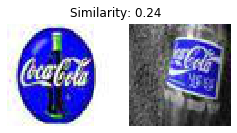

In [43]:
fig = plt.figure(figsize=(4, 2))
plt.suptitle("Similarity: {:.2f}".format(proba))
# show first image
ax = fig.add_subplot(1, 2, 1)
plt.imshow(origA, cmap=plt.cm.gray)
plt.axis("off")
# show the second image
ax = fig.add_subplot(1, 2, 2)
plt.imshow(origB, cmap=plt.cm.gray)
plt.axis("off")
# show the plot
plt.show()